<a href="https://colab.research.google.com/github/imsidharthj/Fastai/blob/main/Fastai_chapter_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm

In [2]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [3]:
!pip install fastkaggle

In [4]:
import os
from pathlib import Path

# iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
# if iskaggle: path = Path('../input/Paddy-Disease-Classification')
# else:
#     path = Path('/content/drive/MyDrive/Colab Notebooks/Paddy Disease Classification')
#     if not path.exists():
#         import zipfile,kaggle
#         kaggle.api.competition_download_cli(str(path))
#         zipfile.ZipFile(f'{path}.zip').extractall(path)

comp = 'paddy-disease-classification'
os.environ['KAGGLE_USERNAME'] = 'imsidharthj'
os.environ['KAGGLE_KEY'] = '6a37f58e98f5572fa4f62ca0bf665f5d'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [5]:
!ls {path}

sample_submission.csv  test_images  train.csv  train_images


In [6]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/test_images')]

In [7]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


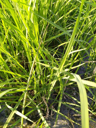

In [8]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [9]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

,count
"(480, 640)",10403
"(640, 480)",4


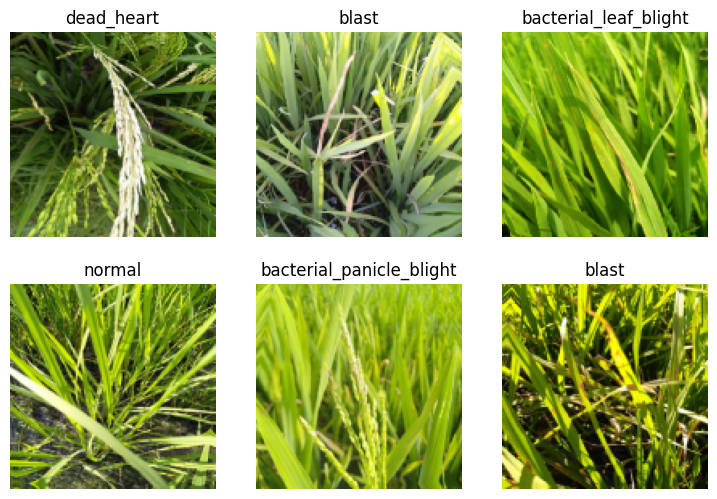

In [10]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

In [11]:
!pip install timm # install the timm library
from fastai.vision.all import * # import the fastai vision library
import timm # import the timm library

learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0014454397605732083, slide=0.0030199517495930195)

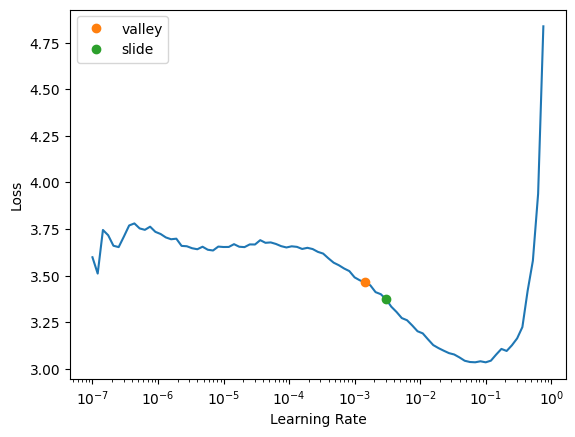

In [12]:
learn.lr_find(suggest_funcs=(valley, slide))

In [13]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.735566,1.218735,0.404133,01:31


epoch,train_loss,valid_loss,error_rate,time
0,1.093771,0.824293,0.275348,01:28
1,0.768049,0.497752,0.162902,01:26
2,0.536771,0.397662,0.120615,01:27


In [14]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [15]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [16]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


tensor([7, 8, 7,  ..., 8, 1, 5])

In [17]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [18]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

,idxs
0,hispa
1,normal
2,hispa
3,blast
4,blast
...,...
3464,dead_heart
3465,hispa
3466,normal
3467,bacterial_leaf_streak


In [19]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,hispa
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [20]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████| 69.8k/69.8k [00:00<00:00, 116kB/s]


In [ ]:
if not iskaggle:
    push_notebook('jhoward', 'Fastai_chapter_6',
                  title='First Steps: Road to the Top, Part 1',
                  file='Fastai_chapter_6.ipynb',
                  competition=comp, private=False, gpu=True)